In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data_bin = pd.read_csv('data/data_processed_bin.csv')
data_cat = pd.read_csv('data/data_processed_cat.csv')

In [14]:
data_bin.head()

,age,label,sex,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
0,16.282192,0,0,94.5,1.65,34.710744,97.00000,20.790000,2.500000,5.568298,...,0.567,0.112,0.196,0.158,0.151,0.436,1.547,1.68,0.881664,0.226844
1,13.432877,0,1,67.0,1.60,26.171875,96.00000,19.100000,2.750000,2.571591,...,0.390,0.250,0.280,0.150,0.130,0.670,1.310,2.52,3.193548,0.161374
2,11.879452,0,1,70.0,1.56,28.763971,74.19685,19.299194,2.701382,0.855838,...,0.950,0.330,0.510,0.130,0.210,0.600,1.710,1.85,2.092457,0.222764
3,10.904110,0,0,62.0,1.45,29.488704,74.19685,19.299194,2.701382,0.855838,...,0.270,0.240,0.470,0.410,0.250,0.430,1.610,2.23,1.568849,0.243139
4,18.265753,0,1,79.5,1.72,26.872634,97.00000,21.640000,2.690000,1.945217,...,0.910,0.190,0.300,0.250,0.470,1.050,1.410,2.98,1.467967,0.170871


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score, precision_score,recall_score,jaccard_score,roc_auc_score

from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [16]:
def perform_evaluation(model, test_data, data_columns, binary, average = "macro"):
    X_test, y_test = test_data
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    cm = confusion_matrix(y_test,preds)
    if binary:
        f1 = f1_score(y_test, preds)
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        roc_auc = roc_auc_score(y_test,preds)
        mislabeled = cm[0][1] + cm[1][0]
    else:
        f1 = f1_score(y_test, preds, average=average)
        precision = precision_score(y_test,preds, average=average)
        recall = recall_score(y_test,preds, average=average)
        roc_auc = roc_auc_score_multiclass(y_test,preds, average=average)

        mislabeled = cm[0][1] + cm[0][2] + cm[1][0] + cm[2][0] + cm[2][1] + cm[1][2]

    prediction_packed = (y_test, preds)

    try:    
        features = pd.DataFrame(index=data_columns.drop('label'),data=model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)[:5]
        features['Feature'] = features.index
        features = features.values.tolist()
    except:
        features = None


    return (prediction_packed, acc, f1, precision, recall, roc_auc, cm, mislabeled), features


def perform_training(data, model):
    X_train, y_train = data
    model.fit(X_train,y_train)

    return model

def prepare_data(data, test_size, binary = True, random = False):
    if random:
        rd_state = np.random.randint(1,100)
    else:
        rd_state = 300464
    X = data.drop(columns=['label'])
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rd_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, y_train), (X_test, y_test)

def check_model(model, data, test_size, data_columns, binary = True, random = False, multi_label_average = "macro"):
    train_data, test_data = prepare_data(data=data, test_size=test_size, binary=binary, random=random)
    trained_model = perform_training(train_data, model=model)
    return perform_evaluation(trained_model, test_data,data_columns, binary=binary, average=multi_label_average)

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict


def convert_metrics_to_dataframe(metrics, models_names):
    data = []
    for idx, model_metric in enumerate(metrics):
        acc = (model_metric[1])
        f1 = (model_metric[2])
        precision = (model_metric[3])
        recall = (model_metric[4])
        roc_auc = (model_metric[5])
        mislabeled = (model_metric[7])
        data.append([models_names[idx],acc,f1, precision, recall, roc_auc, mislabeled])

    columns = ["model", "Acc", "F1", "Precision", "Recall","ROC_AUC", "Mislabeled"]

    return pd.DataFrame(data=data, columns=columns)

def get_best_features(metrics, model_name):
    names = {"Random Forest" :0, "Decision Tree":1, "K-Nearest-Neighbours":2, "Logistic Regression":3, "Support Vector Classifier":4, "Ada Boost":5, "Gradient Boost":6}
    # if metrics[names[model_name]] != None:
    print(metrics[names[model_name]])


### Model tuned hyperparameters for binary classification
_________________________________
RandomForestClassifier()
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}
_________________________________
DecisionTreeClassifier()
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

LogisticRegression()
{'C': 1, 'l1_ratio': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
_________________________________
SVC()
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 0.1, 'n_estimators': 282}
_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 14, 'n_estimators': 173}


In [ ]:
rf_model_bin = RandomForestClassifier(criterion= 'gini',n_estimators=100, max_depth=8,max_features='log2')
dt_model_bin = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features='sqrt', min_samples_leaf=4, min_samples_split=8)
knn_model_bin = KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=2, p=1, weights='uniform')
log_model_bin = LogisticRegression(solver='saga',max_iter=100, C=1, penalty='l1', l1_ratio=0.01)
svc_model_bin = SVC(kernel='rbf', C=10, gamma=0.001)
ada_model_bin = AdaBoostClassifier(n_estimators=282, learning_rate= 0.1)
gb_model_bin = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='exponential', min_samples_split=14, n_estimators=173)

### Model tuned hyperparameters for multiclass classification
_________________________________
RandomForestClassifier()
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}
_________________________________
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
_________________________________
LogisticRegression()
{'C': 1, 'l1_ratio': 0.255, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
_________________________________
SVC()
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 0.1, 'n_estimators': 64}
_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'log_loss', 'min_samples_split': 5, 'n_estimators': 500}

In [ ]:
rf_model_cat = RandomForestClassifier(criterion= 'entropy',n_estimators=500, max_depth=7,max_features='sqrt')
dt_model_cat = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt', min_samples_leaf=2, min_samples_split=3)
knn_model_cat = KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=3, p=1, weights='uniform')
log_model_cat = LogisticRegression(solver='saga',multi_class="ovr",max_iter=100, C=1, penalty='l2', l1_ratio=0.255)
svc_model_cat = SVC(kernel='rbf', C=10, gamma=0.001)
ada_model_cat = AdaBoostClassifier(n_estimators=64, learning_rate= 0.1)
gb_model_cat = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=1.0, loss='log_loss', min_samples_split=5, n_estimators=500)

In [27]:
names = ["Random Forest", "Decision Tree", "K-Nearest-Neighbours", "Logistic Regression", "Support Vector Classifier", "Ada Boost", "Gradient Boost"]

test_size = 0.2
multi_label_average_param = "weighted"

models_bin = [rf_model_bin,dt_model_bin,knn_model_bin,log_model_bin,svc_model_bin,ada_model_bin,gb_model_bin]

metrics_bin = []
metrics_cat = []
features_bin = []
features_cat = []

for model in models_bin:
    metric, feature = check_model(model=model, data=data_bin, data_columns=data_bin.columns, test_size = test_size)
    metrics_bin.append(metric)
    features_bin.append(feature)


models_cat = [rf_model_cat,dt_model_cat,knn_model_cat,log_model_cat,svc_model_cat,ada_model_cat,gb_model_cat]

for model in models_cat:
    metric, feature = check_model(model=model, data=data_cat, data_columns=data_bin.columns, test_size = test_size, binary=False, multi_label_average=multi_label_average_param)
    metrics_cat.append(metric)
    features_cat.append(feature)

p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached wh

In [18]:
get_best_features(features_bin, "Gradient Boost")

[[0.37571526205192374, 'C12:0'], [0.32142568991379034, 'C11:0'], [0.049707449116827396, 'GPx'], [0.03713799383845952, 'C14:1 t'], [0.03499703446769066, 'mean_for_age']]


In [19]:
results_bin = convert_metrics_to_dataframe(metrics_bin, names)
results_cat = convert_metrics_to_dataframe(metrics_cat, names)

In [20]:
results_bin.sort_values(by = "F1", ascending=False)

,model,Acc,F1,Precision,Recall,ROC_AUC,Mislabeled
2,K-Nearest-Neighbours,1.000000,1.000000,1.000000,1.000000,1.000000,0
5,Ada Boost,1.000000,1.000000,1.000000,1.000000,1.000000,0
0,Random Forest,0.981818,0.986301,0.972973,1.000000,0.973684,1
4,Support Vector Classifier,0.981818,0.986301,0.972973,1.000000,0.973684,1
6,Gradient Boost,0.981818,0.986301,0.972973,1.000000,0.973684,1
3,Logistic Regression,0.963636,0.972973,0.947368,1.000000,0.947368,2
1,Decision Tree,0.927273,0.944444,0.944444,0.944444,0.919591,4


In [21]:
results_cat.sort_values(by = "F1", ascending=False)

,model,Acc,F1,Precision,Recall,ROC_AUC,Mislabeled
0,Random Forest,0.963636,0.964227,0.967677,0.963636,"{0: 0.9736842105263157, 1: 0.975, 2: 0.9743589...",2
6,Gradient Boost,0.963636,0.963636,0.963636,0.963636,"{0: 1.0, 1: 0.9607142857142856, 2: 0.955929487...",2
3,Logistic Regression,0.945455,0.946035,0.947594,0.945455,"{0: 0.9736842105263157, 1: 0.9607142857142856,...",3
4,Support Vector Classifier,0.945455,0.946035,0.947594,0.945455,"{0: 0.9736842105263157, 1: 0.9607142857142856,...",3
5,Ada Boost,0.945455,0.944428,0.949987,0.945455,"{0: 0.9722222222222222, 1: 0.925, 2: 0.9871794...",3
1,Decision Tree,0.890909,0.894021,0.908081,0.890909,"{0: 0.9334795321637428, 1: 0.925, 2: 0.9046474...",6
2,K-Nearest-Neighbours,0.818182,0.818997,0.820635,0.818182,"{0: 0.9334795321637428, 1: 0.8678571428571429,...",10


In [175]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    { 
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    },
    {
    'criterion' :['gini', 'entropy'],
     'max_depth' : [4,5,6,7,8],
     'min_samples_split' : np.arange(2,10),
     'min_samples_leaf': np.arange(2,10),
     'max_features': ['sqrt', 'log2'],
    },
    {
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
     'leaf_size' : np.arange(2,10),
     'p' : [1,2],
     'weights' : ['uniform', 'distance'],
     'n_neighbors' : np.arange(2,30)
    },
    {
        'C' : [np.logspace(-3,3,9),1],
        'penalty' : ['l1','l2', 'elasticnet'],
        'max_iter' : [100,1000,5000,10000],
        'l1_ratio' : np.linspace(0.01,0.99,5),
        'solver' : ['saga']
    },
    {
        'C': [0.1,1, 10, 100],
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    {
        'n_estimators' : [int(n) for n in np.linspace(10,500,10)],
        'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
    },
    {
        'n_estimators' : [int(n) for n in np.linspace(10,500,10)],
        'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
        'loss' :  ['log_loss', 'exponential'],
        'criterion' : ['friedman_mse', 'squared_error'],
        'min_samples_split' : np.arange(2,15,3)
    }

]
estimators=[
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    SVC(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

print('#################################################3333')
print('For binary dataset:')
for dataset in [data_bin, data_cat]:

    X = dataset.drop(columns=['label'])
    y = dataset['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=300464)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for estimator, params in zip(estimators, param_grid):
        CV_rfc = GridSearchCV(estimator=estimator, param_grid=params, cv= 5)
        CV_rfc.fit(X_train, y_train)
        print('_________________________________')
        print(estimator)
        print(CV_rfc.best_params_)
    print('#################################################')
    print('For categorical dataset:')

#################################################3333
For binary dataset:
_________________________________
RandomForestClassifier()
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
_________________________________
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

_________________________________
LogisticRegression()
{'C': 1, 'l1_ratio': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
_________________________________
SVC()
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 0.1, 'n_estimators': 282}
_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 14, 'n_estimators': 173}
#################################################3333
For categorical dataset:
_________________________________
RandomForestClassifier()
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}
_________________________________
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbo

p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

_________________________________
LogisticRegression()
{'C': 1, 'l1_ratio': 0.255, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
_________________________________
SVC()
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 0.1, 'n_estimators': 64}


p:\Conda\envs\mgr\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2500 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2500 fits failed with the following error:
Traceback (most recent call last):
  File "p:\Conda\envs\mgr\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "p:\Conda\envs\mgr\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "p:\Conda\envs\mgr\lib\site-packages\sklearn\ensemble\_gb.py", line 431, in fit
    self._check_params()
  File "p:\Conda\envs\mgr\lib\site-packages\sklearn\ensemble\_gb.py", li

_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'log_loss', 'min_samples_split': 5, 'n_estimators': 500}
#################################################3333
For categorical dataset:


p:\Conda\envs\mgr\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
p:\Conda\envs\mgr\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: >

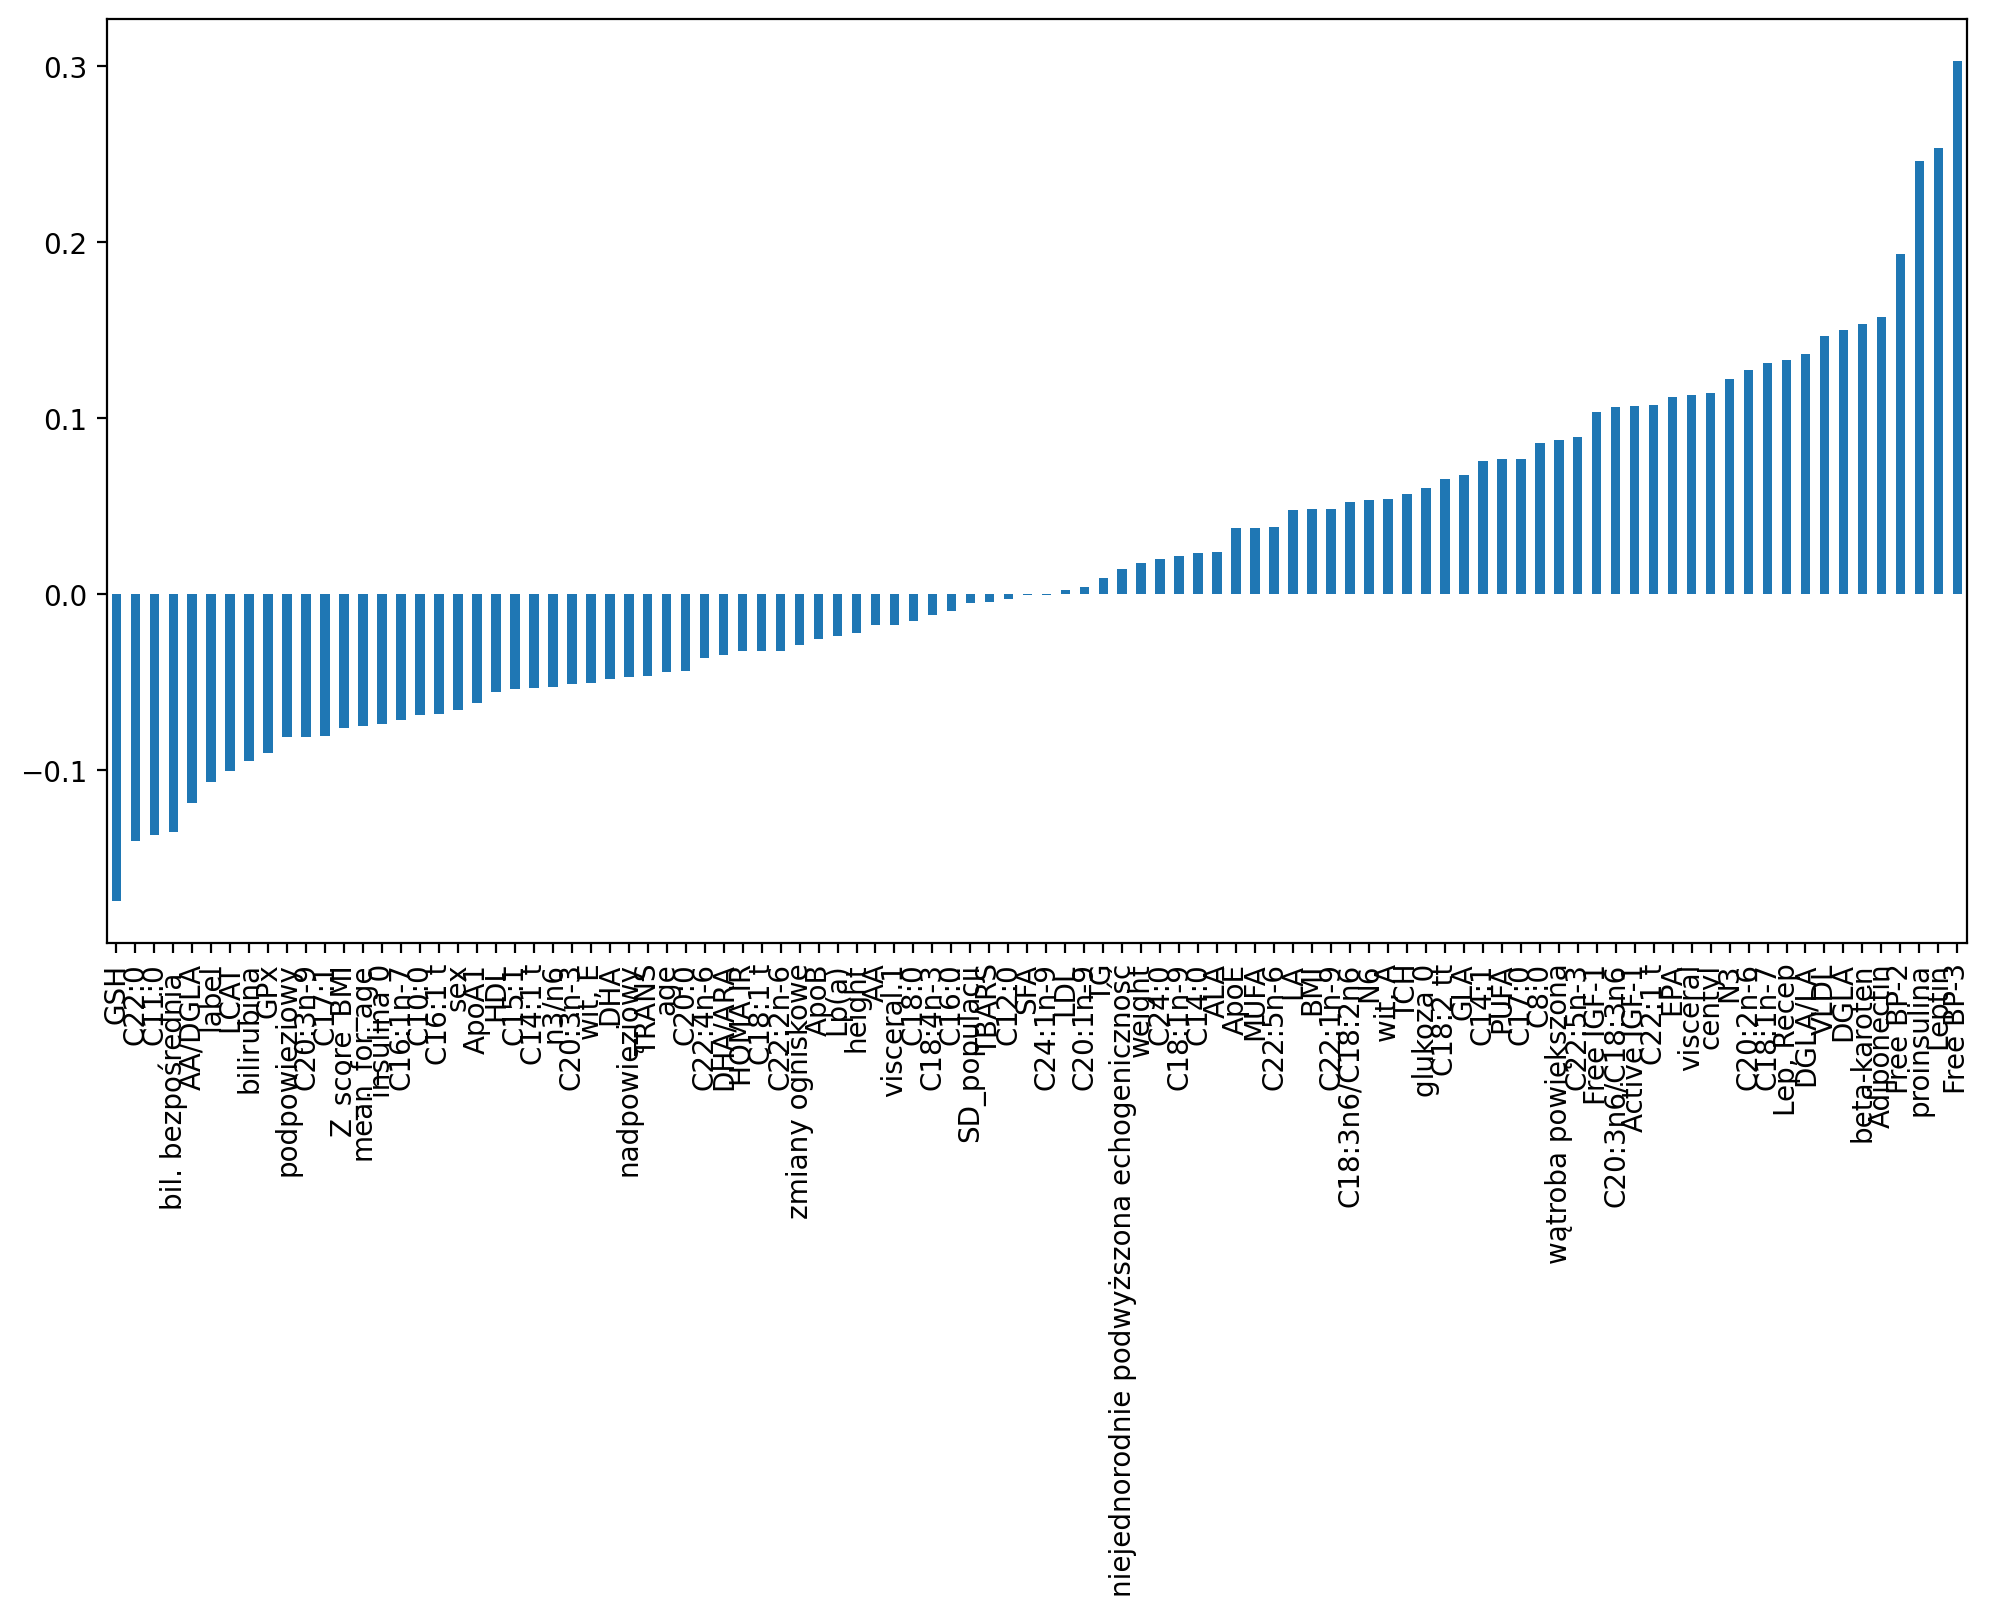

In [29]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)

cluster_labels = model.fit_predict(X)

cluster_data = data_bin.copy()
cluster_data['cluster'] = cluster_labels
cluster_data.corr()['cluster']

plt.figure(figsize=(12,6),dpi=200)
cluster_data.corr()['cluster'].iloc[:-1].sort_values().plot(kind='bar')

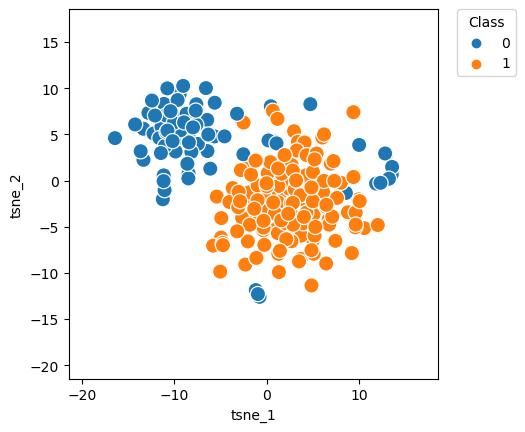

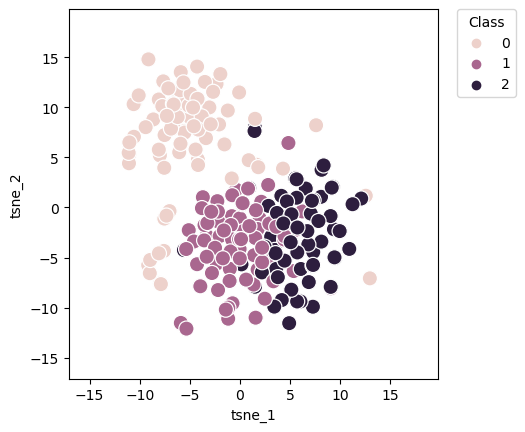

In [25]:

def show_tsne(dataset):
    X = dataset.drop(columns=['label'])
    y = dataset['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=300464)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    from sklearn.manifold import TSNE
    y_true = y_test.copy()
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(X_train)
    tsne_result.shape
    y_true = np.reshape(y_true, (y_true.shape[0],))

    y_tsne = np.reshape(y_train, (y_train.shape[0],))
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_tsne})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title = 'Class')
    plt.show()

for dataset in [data_bin,data_cat]:
    show_tsne(dataset)